## Image classification with Vision Transformer

<b>Author</b>: <a href="https://www.linkedin.com/in/khalid-salama-24403144/">Khalid Salama</a> <br/>
<b>Date created</b>: 2021/01/18 <br/>
<b>Last modified</b>: 2021/01/18 <br/>
<b>Description</b>: Implementing the Vision Transformer (ViT) model for image classification.

<div style="background-color: blue; color: white; width: '100%'; text-align: center; font-weight: bold; font-size: '150%';"> This example uses Keras 3</div>

### Introduction

<hr />

This example implements the <a href="https://arxiv.org/abs/2010.11929">Vision Transformer (ViT)</a> model by Alexey Dosovitskiy et al. for image classification, and demonstrates it on the CIFAR-100 dataset. The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.

<hr />

## Setup

In [2]:
import keras
print(keras.__version__)

2.15.0


In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
#from keras import ops ## ops only included in Keras 3+

import numpy as np
import matplotlib.pyplot as plt

<hr />

### Prepare the data

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 412s 2us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


<hr />

### Configure the hyperparameters

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

<hr />

### Use data augmentation

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2024-06-04 03:55:21.313868: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.


<hr />

### Implement multilayer perceptron (MLP)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

<hr />

### Implement patch creation as a layer

In [8]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Let's display patches for a sample image

NameError: name 'ops' is not defined

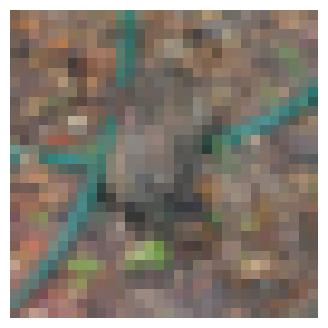

In [10]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

#resized_image = ops.image.resize(  ## For Keras version 3+
#    ops.convert_to_tensor([image]), size=(image_size, image_size)
#)
resized_image = keras(  ## For Keras version 2.15
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

<hr />

### Implement the patch encoding layer

The <font color="red">PatchEncoder</font> layer will linearly transform a patch by projecting it into a vector of size <font color="red">projection_dim</font>. In addition, it adds a learnable position embedding to the projected vector.

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config